# A Hitchhiker's Guide to Indian Patent Analytics

This notebook is intended to be read with the article of the same title [published on LinkedIn](https://www.linkedin.com/pulse/hitchhikers-guide-indian-patent-analytics-sanjay-dasgupta).

Please note that all outputs (except the scatter-plot at the end) have been cleared to reduce the size of the saved notebook.

### Preliminaries

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load Excel File Downloaded from Patentscope

In [ ]:
df = pd.read_excel('resultList2.xls', 'ResultSet')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

print('Data has %d rows and %d columns' % df.shape)
print('Column names: %s' % ', '.join(df.columns))

# Preliminary Data Analysis and Enrichment

### Add a *company* column

In [ ]:
df['company'] = np.where(df['applicants'].str.contains('TATA STEEL'), 
    'TATA', 'SAIL')

### Calculate and Display Relative Patent Counts

In [ ]:
counts = df['company'].value_counts()

print(counts)
print('')

ax = counts.plot.pie(figsize=(5, 5))
ax.set_title('Relative Counts', fontsize=18)
ax.set_ylabel('')
None

### Display Some Sample Data

In [ ]:
df[['publication_number', 'publication_date', 'title', 'ipc', 'company', 'inventors']].sample(5)

# *Feature Engineering* -- Convert IPC codes into Text (*Sentences*)

Convert the IPC codes into *sentences* to facilitate subsequent processing with scikit-learn's [text-feature-extraction](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) capabilities.

### Extract IPC codes into arrays

In [ ]:
ipc_regex = re.compile('[A-H]\s*[0-9]{2}\s*[A-Z]\s*(?:[0-9]+(?:/(?:[0-9]+)?)?)?')

df['ipc_list'] = df['ipc'].str.findall(ipc_regex)
df = df[df['ipc_list'].str.len() != 0]

print('Count of records with IPCs: %d' % len(df))
ipclen = df['ipc_list'].str.len()
print('IPC nbr: min=%d, mean=%f, max=%d' % (ipclen.min(), ipclen.mean(), ipclen.max()))

### IPC to Sentence Converter

In [ ]:
ipc_pattern = '([A-H])\s*(?:(\d{2})\s*(?:([A-Z])\s*(?:(\d+)\s*(?:/\s*(\d+))?)?)?)?'
ipcregex = re.compile(ipc_pattern)

def ipc_sentence(ipc):
    parts = [part.strip('[ /]') for part in re.match(ipcregex, ipc).groups() if part]
    s = parts[0]
    if len(parts) > 1:
        s += ' ' + parts[0] + parts[1]
        if len(parts) > 2:
            s += ' ' + parts[0] + parts[1] + parts[2]
            if len(parts) > 3:
                s += ' ' + parts[0] + parts[1] + parts[2] + parts[3]
                if len(parts) > 4:
                    s += ' ' + parts[0] + parts[1] + parts[2] + parts[3] + parts[4]
    return s

def multi_ipc_sentence(ipcs):
    return ' '.join([ipc_sentence(ipc) for ipc in ipcs])

### Test IPC to Sentence Conversion

In [ ]:
multi_ipc_sentence(['A 13 K 127 / 999'])

### Convert all IPC Codes

### Display Converted Sentence Samples

In [ ]:
ipc_sentence = df['ipc_list'].map(multi_ipc_sentence)
ipc_sentence.sample(10)

# Apply Text-Processing Techniques

### Generate TF-IDF Word Counts

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, stop_words='english').fit(ipc_sentence)
tf = vectorizer.transform(ipc_sentence)
print('Rows: %d, Features: %d' % tf.shape)

# Prepare Word Counts for Scatter Plot Display

### Use TruncatedSVD to Reduce to 50 Features

In [ ]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=50)
tsvd100 = tsvd.fit_transform(tf)
print('Rows: %d, Features: %d' % tsvd100.shape)

### Use t-SNE to Obtain 2-D (X, Y) Mapping

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(tsvd100)
print('Rows: %d, Features: %d' % tsne.shape)

In [ ]:
tsne[:10, :]

### Scatter Plot of 2-D Data

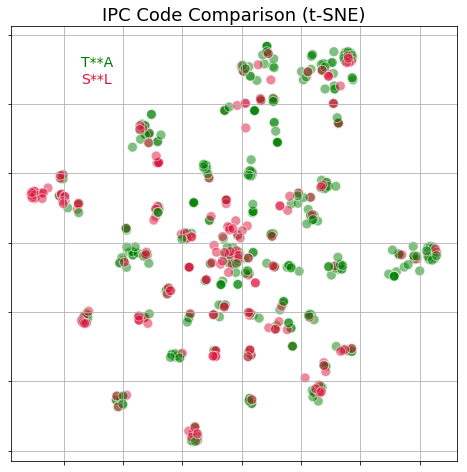

In [15]:
color1 = 'green'
color2 = 'crimson'
tsne_df = pd.DataFrame(tsne, columns=['x', 'y'])
colors = np.where(df['company'] == 'TATA', color1, color2)
ax = tsne_df.plot.scatter(x='x', y='y', figsize=(8, 8), grid=True, 
   alpha=0.5, color=colors, edgecolors='white', s=96)
ax.set_xlabel('')
ax.set_ylabel('')
ax.text(-27, 25.5, 'T**A', color=color1, fontsize=14)
ax.text(-27, 23, 'S**L', color=color2, fontsize=14)
ax.set_title('IPC Code Comparison (t-SNE)', fontsize=18)
ax.set_xticklabels(['' for i in range(6)])
ax.set_yticklabels(['' for i in range(7)])
plt.savefig('ipc-scatter-tsne.png')
None